In [1]:
from __future__ import print_function, division
import time
import os
import copy
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

from scipy.stats import zscore
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy.spatial.distance import pdist, squareform

from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.manifold import TSNE

from PIL import Image  

In [2]:
#@title Figure Settings

%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.ion()   # interactive mode

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['figure.figsize'] = (8, 6)

In [3]:
#@title Data augmentation and normalization

data_transforms = transforms.Compose([
        #transforms.RandomRotation(30),
        #transforms.RandomPerspective(distortion_scale=0.1, p=0.5, interpolation=3, fill=0),
        transforms.RandomResizedCrop(120),
        transforms.RandomHorizontalFlip(p=0.5),
        #transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(), # 对我们的灰度图来说，这已经normalize了，把0~255map到01，直接除以255
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

先在自己的google硬盘里面，my drive目录下创建一个文件夹“kay”，然后把我给大家的压缩包放进去。

In [32]:
#@title 提取 kay/gallent dataset

data_dir = 'stimuli'
!rm -rf 'stimuli//.ipynb_checkpoints'
stim_datasets = datasets.ImageFolder(os.path.join(data_dir), transform=data_transforms)
class_names = stim_datasets.classes
dataset_sizes = {
    'train': 1500,
    'val': 250,
}
batch_size = 20
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [33]:
class_names

['animate_animals',
 'animate_human',
 'inanimate_artificial',
 'inanimate_natural']

In [34]:
#@title 把数据放到一个dataload里面

xx, yy = torch.utils.data.random_split(stim_datasets, [dataset_sizes['train'], dataset_sizes['val']])
dataloaders = {
    'train': torch.utils.data.DataLoader(xx, batch_size=20, shuffle=True, num_workers=8),
    'val': torch.utils.data.DataLoader(yy, batch_size=20, shuffle=True, num_workers=8),
}

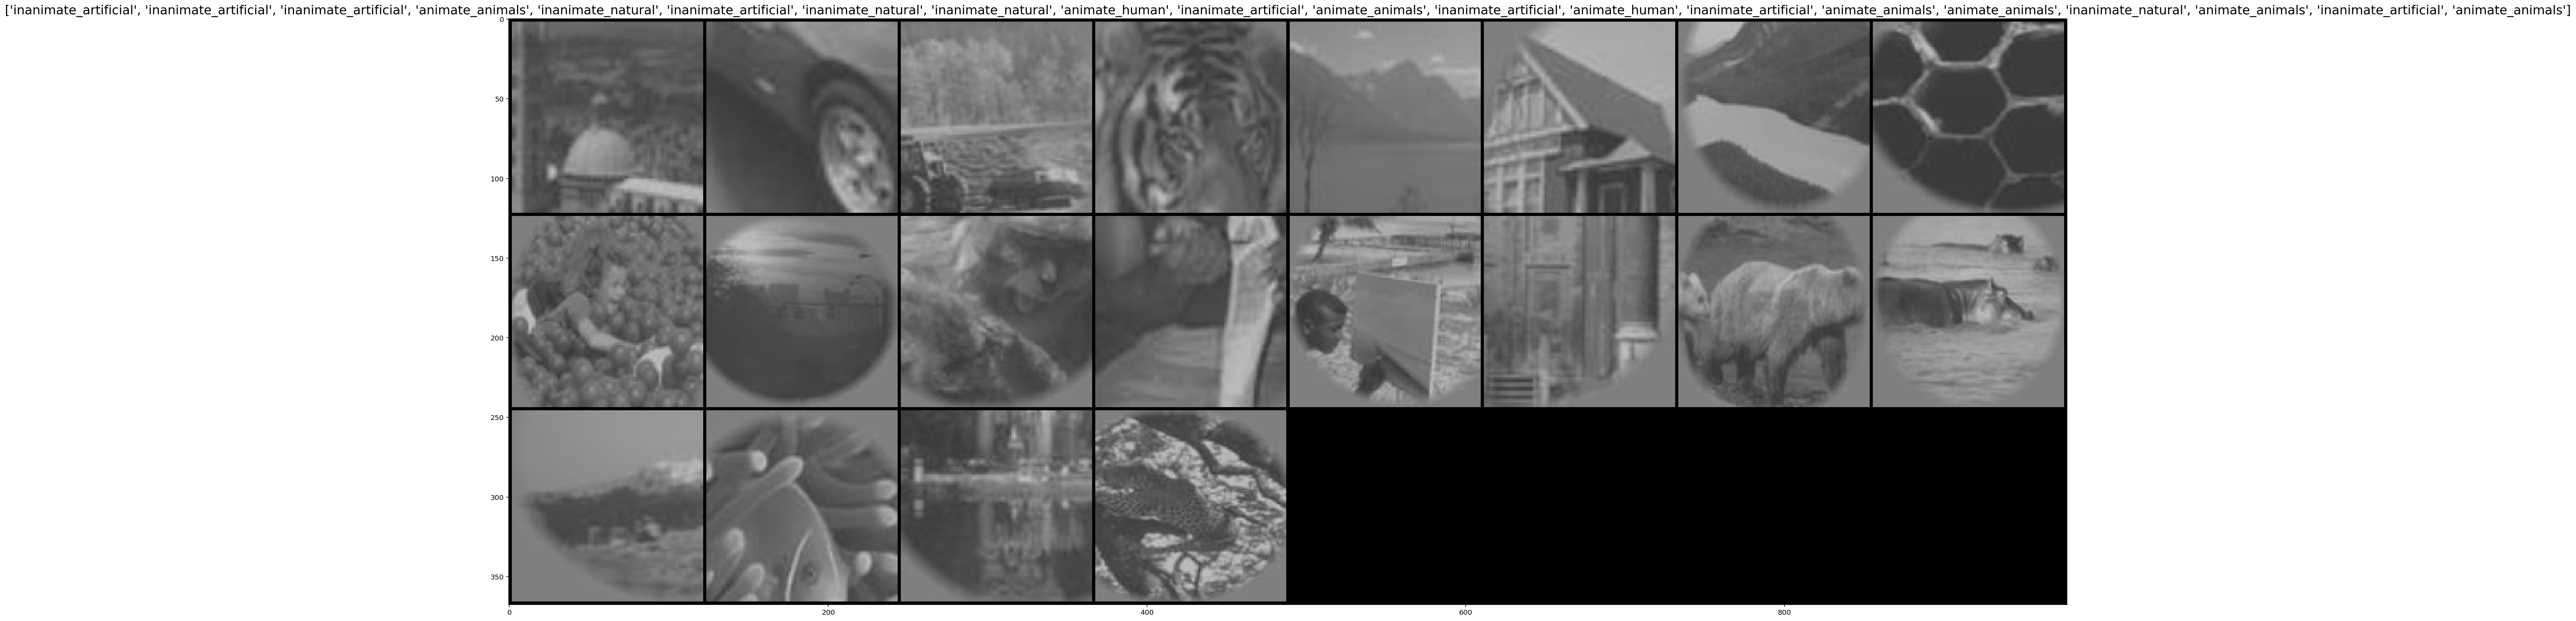

In [35]:
#@title Visualize a few images

def imshow(inp, title=None, figsize=[40, 25]):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=figsize)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [36]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        xx, yy = torch.utils.data.random_split(stim_datasets, [dataset_sizes['train'], dataset_sizes['val']])

        dataloaders = {
            'train': torch.utils.data.DataLoader(xx, batch_size=batch_size, shuffle=True, num_workers=1),
            'val': torch.utils.data.DataLoader(yy, batch_size=batch_size, shuffle=True, num_workers=1),
        }

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualizing the model predictions

Generic function to display predictions for a few images

In [37]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j], figsize=[5, 5])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [38]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 4. 因为我们是4类
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()  #.to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.8)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.




In [39]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)

Epoch 0/29
----------
train Loss: 1.6297 Acc: 0.4493
val Loss: 3.0539 Acc: 0.3680

Epoch 1/29
----------
train Loss: 1.5349 Acc: 0.4560
val Loss: 1.3439 Acc: 0.3280

Epoch 2/29
----------
train Loss: 1.2501 Acc: 0.5200
val Loss: 1.3200 Acc: 0.4640

Epoch 3/29
----------
train Loss: 1.2826 Acc: 0.5260
val Loss: 5.1704 Acc: 0.2800

Epoch 4/29
----------
train Loss: 1.1830 Acc: 0.5593
val Loss: 1.1125 Acc: 0.5560

Epoch 5/29
----------
train Loss: 1.3140 Acc: 0.5700
val Loss: 1.4886 Acc: 0.2680

Epoch 6/29
----------
train Loss: 1.5893 Acc: 0.4460
val Loss: 1.4634 Acc: 0.4600

Epoch 7/29
----------
train Loss: 1.1531 Acc: 0.5447
val Loss: 1.1447 Acc: 0.5200

Epoch 8/29
----------
train Loss: 0.9912 Acc: 0.5993
val Loss: 0.8825 Acc: 0.6160

Epoch 9/29
----------
train Loss: 0.9451 Acc: 0.5953
val Loss: 0.9783 Acc: 0.5920

Epoch 10/29
----------
train Loss: 0.9437 Acc: 0.6133
val Loss: 0.9094 Acc: 0.6320

Epoch 11/29
----------
train Loss: 0.8942 Acc: 0.6353
val Loss: 0.8698 Acc: 0.6560

Ep

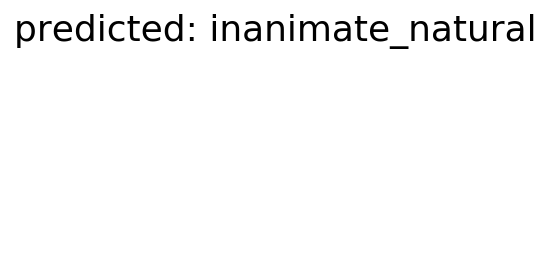

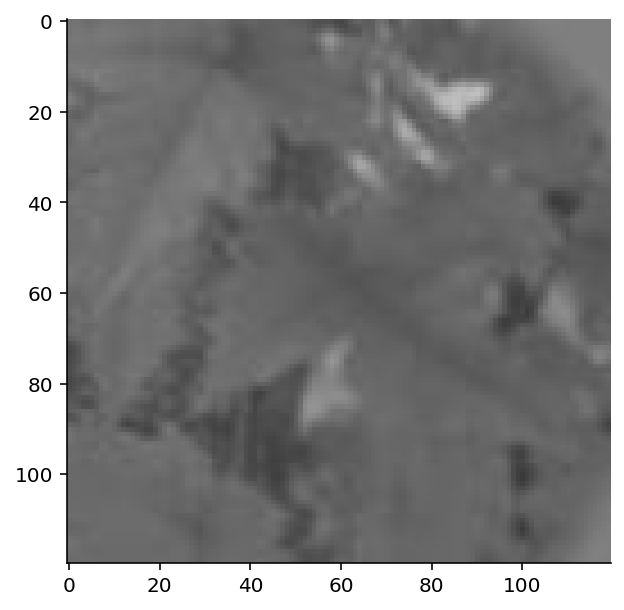

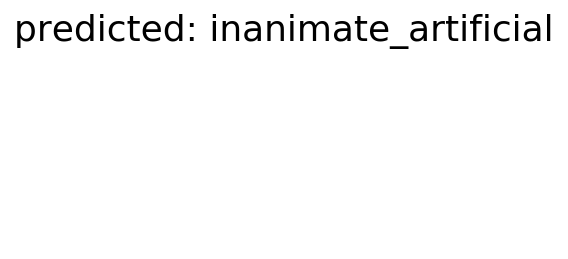

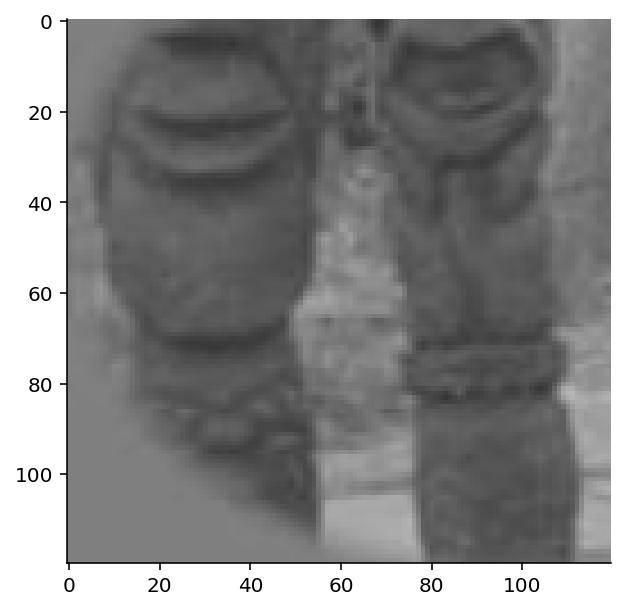

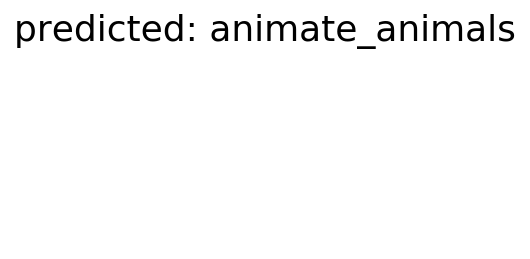

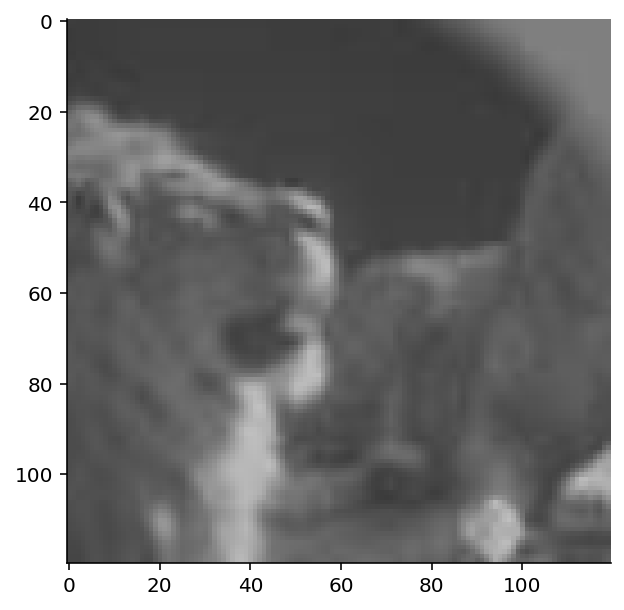

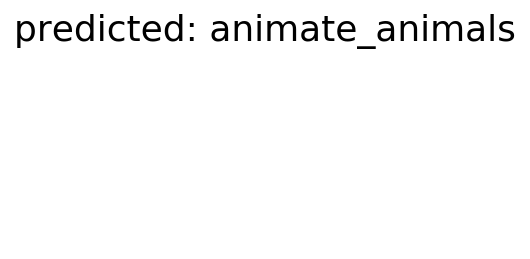

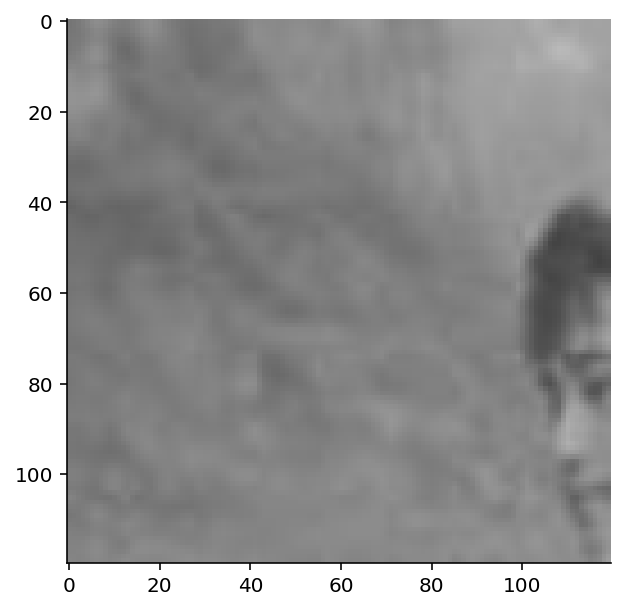

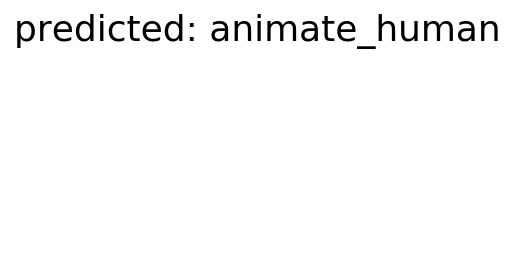

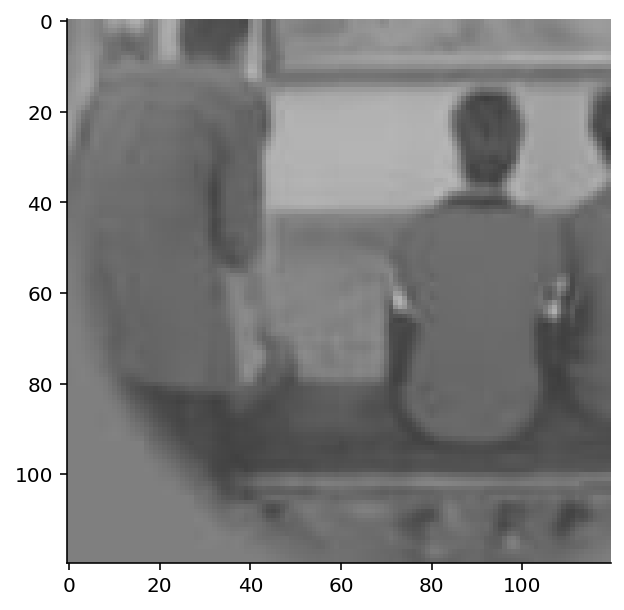

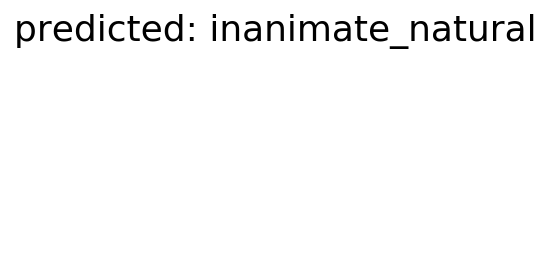

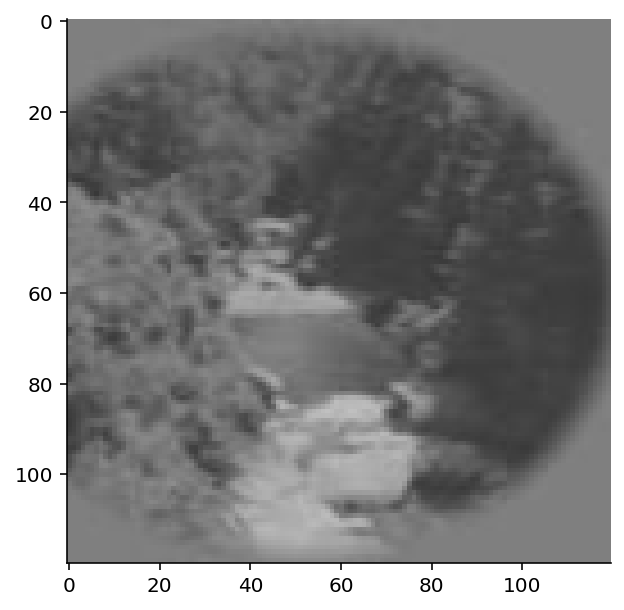

In [40]:
visualize_model(model_ft)

# 从图片中得到数据和标签


In [41]:
categories = os.listdir(data_dir)

training_data = [0] * 1750 
training_labels = [0] * 1750 
training_labels_name = [0] * 1750 
labels2num = {str(categories[i]): i for i in range(len(categories))}

for category in categories:
    files = os.listdir(data_dir+'//' + category)
    for file in files:
        training_index = int(file.split("_")[0])
        im = Image.open(data_dir + '//' + category + '//' + file)
        training_data[training_index] = np.array(im)
        training_labels[training_index] = labels2num[category]
        training_labels_name[training_index] = category

training_data = np.array(training_data)
training_labels = np.array(training_labels)
training_data.shape

(1750, 128, 128)

# 把神经网络的representation拿出来看看结果
Goal: extracting our deep CNN model's representations of these same stimuli

We'll run these very same stimuli through our CNN model and use the get_hidden_activity() function to store its internal representations. The output of this function is a Python dict, which contains a matrix of population responses (just like resp_v1) for each layer of the network specified by the layer_labels argument. 



In [42]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [43]:
def get_hidden_activity(net, stimuli):
    """Retrieve internal representations of network

    Args:
      net (nn.Module): a NN model
      stimuli (torch.Tensor): batchsize x 1 x 128 x 128 tensor 

    Returns:
      dict: internal representations at each layer of the network, in
        numpy arrays. The keys of this dict are the strings in layer_labels.

    """
    feature_out = {}
    layers_name = list(net._modules.keys())
    layers = list(net._modules.values())

    def hook_fn_forward(module, input, output):
        # Attach 'hooks' to each layer of the network to store hidden representations in hidden_activity
        layer_name = layers_name[np.argwhere([module == m for m in layers])[0, 0]]
        feature_out[layer_name] = output
    
    handles = {}
    modules = net.named_children()
    for name, module in modules:
        handles[name] = module.register_forward_hook(hook_fn_forward)

    net.eval() 
    with torch.no_grad():
        pred = net(stimuli)
        for k, v in handles.items():
            handles[k].remove()
            
    return feature_out

In [44]:
# stimuli to get hidden activity
x = torch.from_numpy(training_data)
x = x.unsqueeze(1)
x = x.float()
x = x.to(device)
x.shape

torch.Size([1750, 1, 128, 128])

In [45]:
model_ft.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_ft.to(device)
1

1

In [ ]:
hidden_activity = get_hidden_activity(model_ft, x)
print(hidden_activity.keys())
print(hidden_activity['conv1'].shape)

In [ ]:
np.save("hidden_activity.npy", hidden_activity)

In [ ]:
torch.save(hidden_activity, 'hidden_activity.pt')

In [ ]:
np.save("output.npy", hidden_activity)

In [ ]:
!ls

## RDM
RDM 我写了两种方法，一种是用相关算的，一种用距离算的。

In [ ]:
def plot_corr_matrix(rdm, ax=None, vmax=2.0):
    """Plot dissimilarity matrix

    Args:
      rdm (numpy array): n_stimuli x n_stimuli representational dissimilarity 
        matrix
      ax (matplotlib axes): axes onto which to plot

    Returns:
      nothing
    
    """
    if ax is None:
      ax = plt.gca()

    cax = ax.imshow(rdm, vmin=0.0, vmax=vmax)
    ax.set_aspect('auto')

    if rdm.shape[0] == 4:
        ax.set_xticks([i for i in range(4)])
        ax.set_yticks([i for i in list(range(4))[::-1]])
        ax_label = list(labels2num.keys())
        ax.set_xticklabels([ax_label[i] for i in range(4)], rotation=30)
        ax.set_yticklabels([ax_label[i] for i in list(range(4))[::-1]], rotation=40)
    else:
        ax.set_xticks([])
        ax.set_yticks([])
    cbar = plt.colorbar(cax, ax=ax, label='correlation coefficient')

def RDM(resp, methods='corr'):
    """Compute the representational dissimilarity matrix (RDM)

    Args:
      resp: S x N matrix with population responses to
        each stimulus in each row
    
    Returns:
      np.ndarray: S x S representational dissimilarity matrix
    """
    if methods == 'corr':
        zresp = zscore(resp, axis=1)  # z-score responses to each stimulus
        result = 1 - (zresp @ zresp.T) / zresp.shape[1]
    elif methods == 'dist':
        # pdist just returns the upper triangle of the pairwise distance matrix
        pair_dist = pdist(resp)
        # to get the whole (20, 20) array we can use squareform
        result = squareform(pair_dist)
    return result

In [ ]:
sorted_labels = np.sort(training_labels)

In [ ]:
def transform_resp(layer_name, hidden_activity=hidden_activity):
    # 把hidden activity从GPU取出来，才能转换成numpy数组
    layer_resp = hidden_activity['conv1'].cpu().numpy()
    # 把四维数组变成二维数组
    layer_resp = layer_resp.reshape([1750, -1, 1, 1]) 
    layer_resp = layer_resp.squeeze()
    return layer_resp

In [ ]:
conv1_resp = transform_resp('conv1')
conv1_rdm = RDM(conv1_resp[sorted_labels], 'dist')

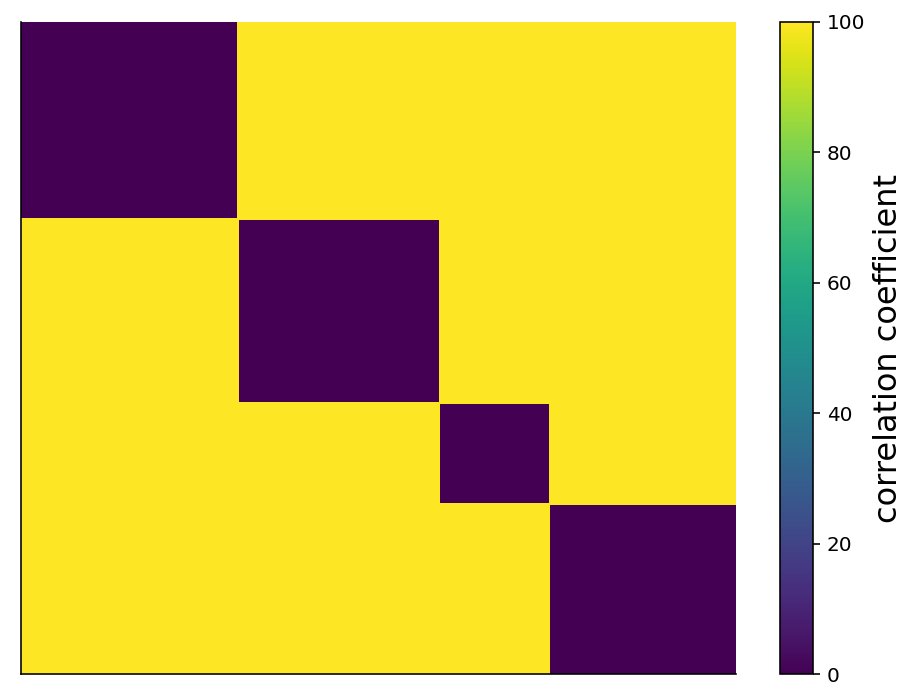

In [ ]:
plot_corr_matrix(conv1_rdm, vmax=100)

In [ ]:
maxpool_resp = transform_resp('maxpool')
maxpool_rdm = RDM(maxpool_resp[sorted_labels], 'dist')

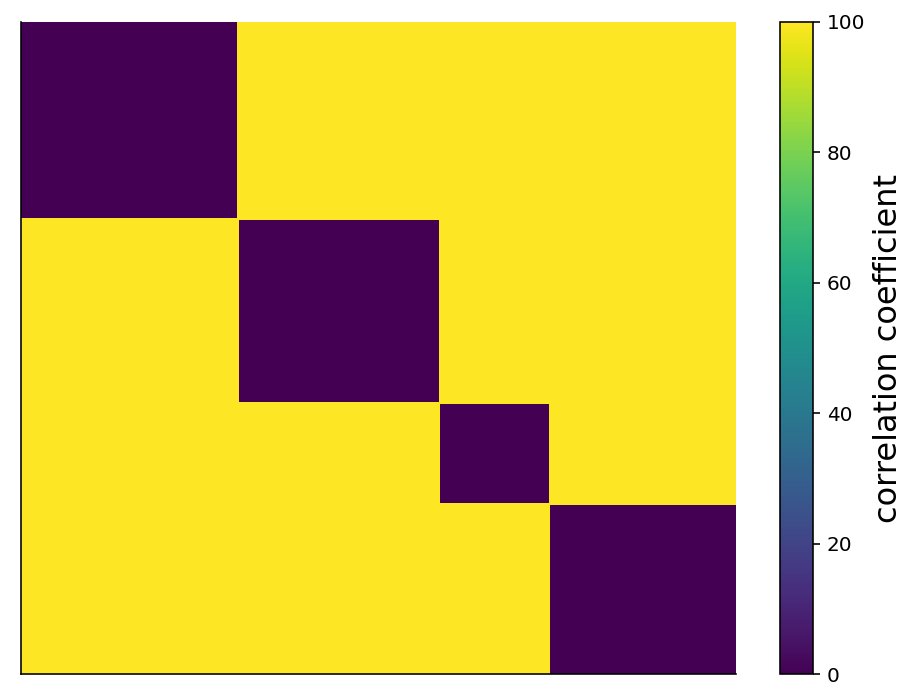

In [ ]:
plot_corr_matrix(maxpool_rdm, vmax=100)

In [ ]:
layer4_resp = transform_resp('layer4')
layer4_rdm = RDM(layer4_resp[sorted_labels], 'dist')

In [ ]:
plot_corr_matrix(layer4_rdm, vmax=100)

## 降维可视化


In [ ]:
# 还需要降维，不然有的没法运算
ipca = IncrementalPCA(n_components=200, batch_size=200)
transformer.partial_fit(X[:100, :])

In [ ]:
ipca.fit(conv1_resp)

/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_incremental_pca.py:309: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
transformer.partial_fit(X[:100, :])

In [ ]:
ipca = IncrementalPCA(n_components=500, batch_size=500)

In [ ]:
conv1_resp_lowd = ipca.fit_transform(conv1_resp)